In [1]:
import os
import time
import random
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import seaborn as sns

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

import cv2

2024-07-24 17:58:00.151276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 17:58:00.151378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 17:58:00.288526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/facialexpression/dataset'
data_path = '/kaggle/input/facialexpression/data.csv'
data = pd.read_csv(data_path)
data.head()

Unnamed: 0                                               path     label
0           0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1           1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2           2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3           3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4           4       Surprise/cropped_emotions.263616~12fffff.png  Surprise

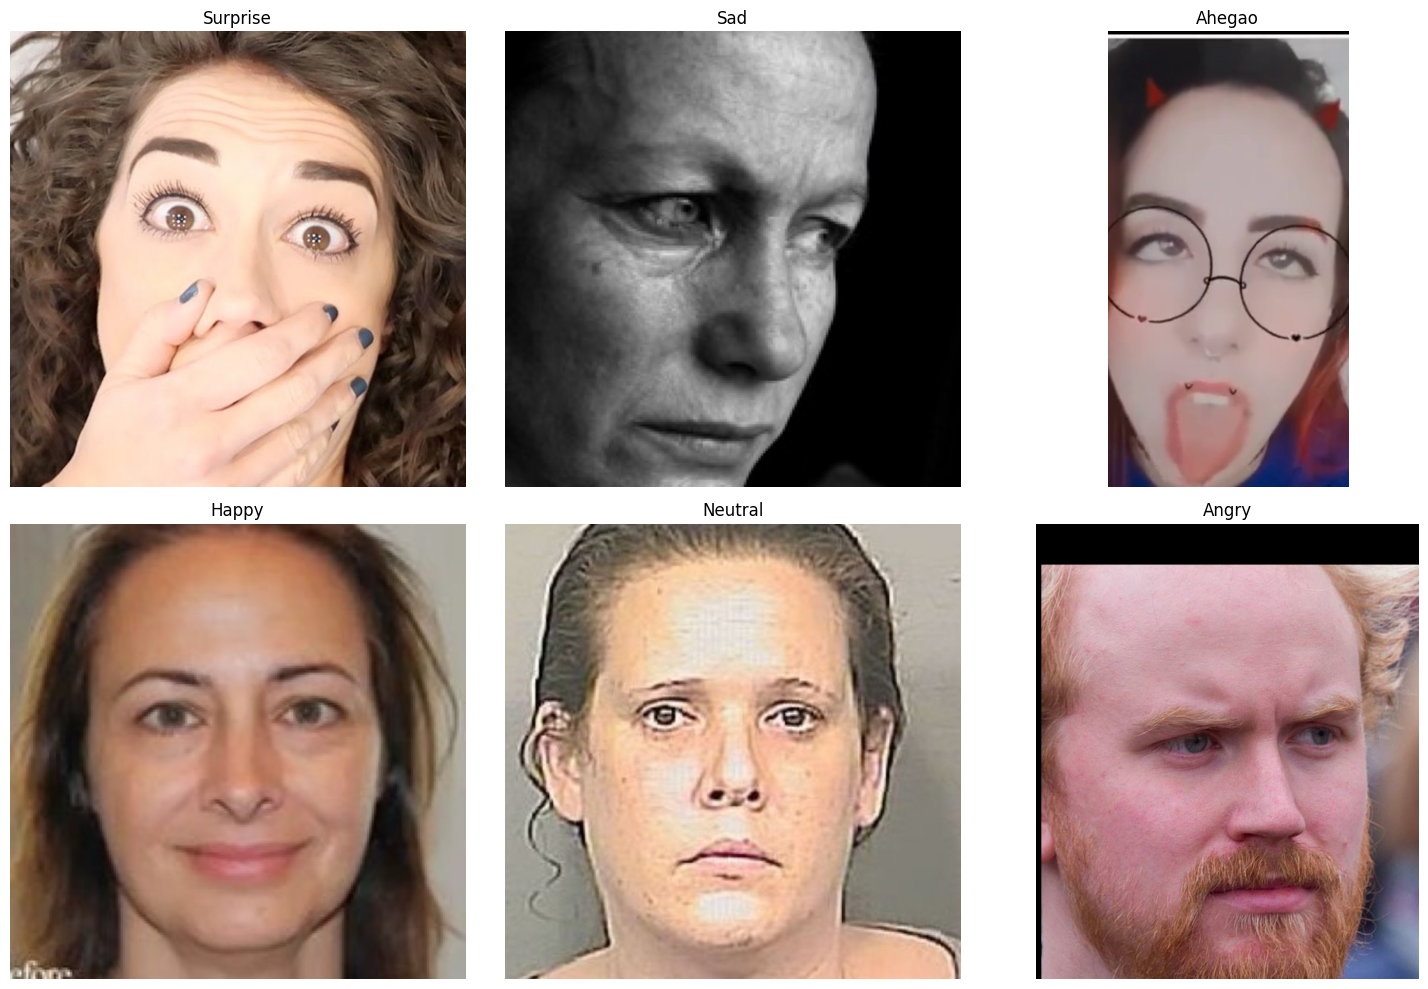

In [3]:
# Get unique expressions
unique_expressions = data['label'].unique()

# Prepare a figure to display the images
plt.figure(figsize=(15, 10))

for i, expression in enumerate(unique_expressions):
    # Get the first image path for each expression
    sample_image_path = data[data['label'] == expression]['path'].values[0]
    full_image_path = os.path.join(base_dir, sample_image_path)
    
    # Read and display the image
    image = cv2.imread(full_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title(expression)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
label_counts = data['label'].value_counts()

# Display the counts
print(label_counts)

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64


In [5]:
data.shape

(15453, 3)

In [6]:
# Split the dataset
train_val_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)

# Prepare the data generators
train_val_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_val_datagen.flow_from_dataframe(
    dataframe=train_val_data,
    directory=base_dir,
    x_col='path',
    y_col='label',
    subset='training',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224)
)

validation_generator = train_val_datagen.flow_from_dataframe(
    dataframe=train_val_data,
    directory=base_dir,
    x_col='path',
    y_col='label',
    subset='validation',
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224)
)
    
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=base_dir,
    x_col='path',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224)
)

Found 11126 validated image filenames belonging to 6 classes.
Found 2781 validated image filenames belonging to 6 classes.
Found 1546 validated image filenames belonging to 6 classes.


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # Number of classes
])

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #model compilation

**Model Training (Model 1)**

In [9]:
# Train the model (#Model1)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

Epoch 1/10


2024-07-24 18:00:28.827025: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-07-24 18:00:28.827081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-07-24 18:00:28.827098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-07-24 18:00:28.827117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-07-24 18:00:28.827130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-07-24 18:00:28.827141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-07-24 18:00:28.827152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-07-24 18:00:28.827163: E 

  1/348 ━━━━━━━━━━━━━━━━━━━━ 55:13 10s/step - accuracy: 0.1875 - loss: 1.8066

I0000 00:00:1721844033.503565     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


323/348 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.2441 - loss: 3.2020

2024-07-24 18:02:01.200468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.69728, expected 5.86672
2024-07-24 18:02:01.200525: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.9884, expected 5.15784
2024-07-24 18:02:01.200541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 6.99726, expected 6.1667
2024-07-24 18:02:01.200553: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 6.94084, expected 6.11028
2024-07-24 18:02:01.200565: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 6.488, expected 5.65744
2024-07-24 18:02:01.200576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 7.10107, expected 6.27051
2024-07-24 18:02:01.200586: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 7.22553, expected 6.39497
2024-07-24 18:02:01.200597: E external/local_xla/xla/

347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.2447 - loss: 3.1238

2024-07-24 18:02:32.030358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98571: 7.85584, expected 6.9528
2024-07-24 18:02:32.030415: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98572: 7.75013, expected 6.84708
2024-07-24 18:02:32.030425: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98574: 6.99864, expected 6.09559
2024-07-24 18:02:32.030439: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98575: 7.56104, expected 6.65799
2024-07-24 18:02:32.030447: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98576: 7.30434, expected 6.40129
2024-07-24 18:02:32.030455: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98577: 7.15909, expected 6.25604
2024-07-24 18:02:32.030463: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98579: 5.28927, expected 4.38623
2024-07-24 18:02:32.030471: 

348/348 ━━━━━━━━━━━━━━━━━━━━ 130s 346ms/step - accuracy: 0.2447 - loss: 3.1177 - val_accuracy: 0.2521 - val_loss: 1.7153
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.2576 - loss: 1.7063 - val_accuracy: 0.2521 - val_loss: 1.6694
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.2655 - loss: 1.6722 - val_accuracy: 0.2521 - val_loss: 1.6506
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.2600 - loss: 1.6635 - val_accuracy: 0.2521 - val_loss: 1.6434
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 72s 204ms/step - accuracy: 0.2659 - loss: 1.6599 - val_accuracy: 0.2521 - val_loss: 1.6408
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.2561 - loss: 1.6592 - val_accuracy: 0.2521 - val_loss: 1.6399
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.2624 - loss: 1.6599 - val_accuracy: 0.2521 - val_loss: 1.6394
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.2623 - loss: 1.6586 - va

In [10]:
model.evaluate(test_generator)

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2792 - loss: 1.6435

2024-07-24 18:27:58.014007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 6.45994, expected 5.58188
2024-07-24 18:27:58.014080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 7.29622, expected 6.41816
2024-07-24 18:27:58.014090: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 7.04038, expected 6.16233
2024-07-24 18:27:58.014098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 7.65045, expected 6.77239
2024-07-24 18:27:58.014106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 7.54658, expected 6.66853
2024-07-24 18:27:58.014114: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65: 7.32394, expected 6.44589
2024-07-24 18:27:58.014122: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 7.37872, expected 6.50066
2024-07-24 18:27:58.014129: E external/local_xla

49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.2785 - loss: 1.6438


[1.6522051095962524, 0.2606727182865143]

**Confusion matrix and ROC- AUC curve¶**

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step


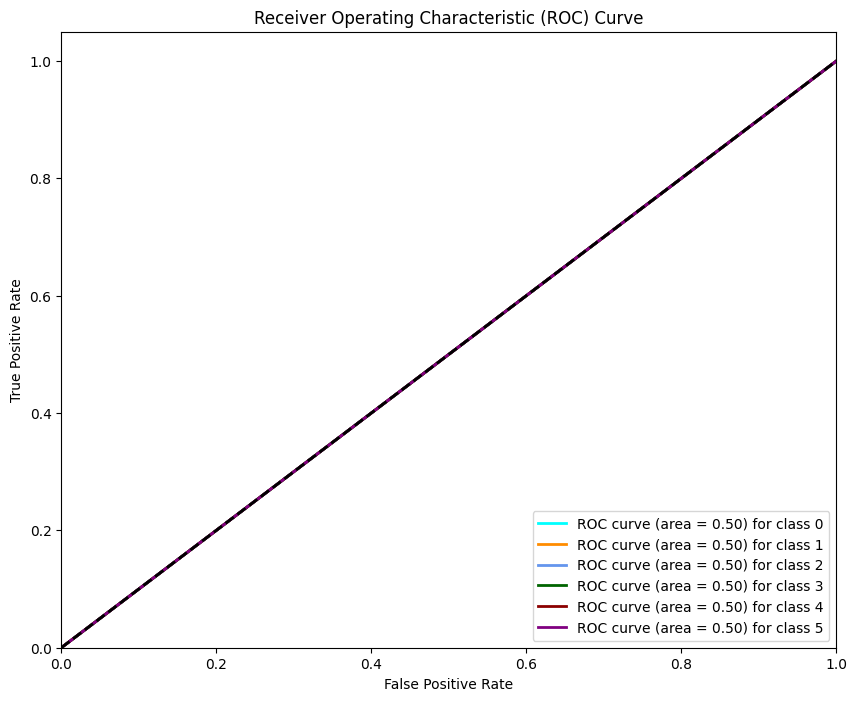

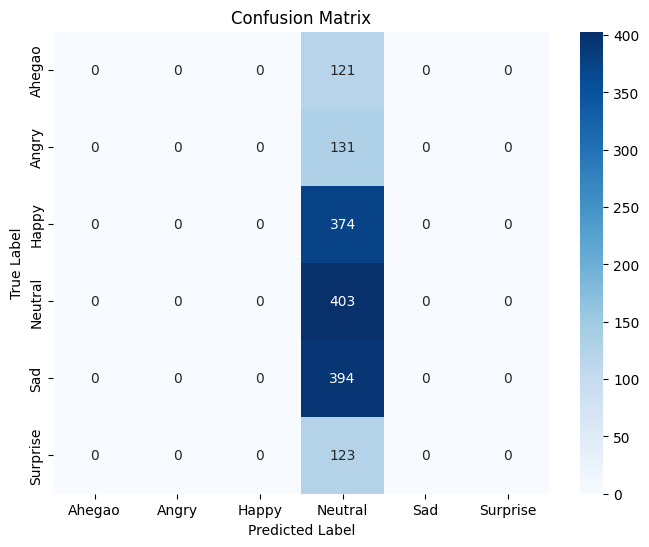

In [11]:
# Predict probabilities for test set
y_pred_proba = model.predict(test_generator)

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = np.argmax(y_pred_proba, axis=1)

# Binarize the labels
lb = LabelBinarizer()
y_true_binary = lb.fit_transform(y_true)
if y_true_binary.shape[1] == 1:
    y_true_binary = np.hstack((1 - y_true_binary, y_true_binary))

# Compute ROC curve and ROC area for each class
n_classes = len(test_generator.class_indices)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Limiting the data because of class imabalance**


In [12]:
# Set the number of samples for each category
num_samples = 1205

# Create a new dataframe by sampling the required number of samples for each label
limited_data = data.groupby('label').apply(lambda x: x.sample(num_samples)).reset_index(drop=True)

# Display the counts of each label in the new dataframe
print(limited_data['label'].value_counts())

label
Ahegao      1205
Angry       1205
Happy       1205
Neutral     1205
Sad         1205
Surprise    1205
Name: count, dtype: int64


**Model interpretability using Lime**

In [13]:
def explain_prediction(model, test_generator, class_names, predicted_label, true_label, num_samples=3):
    # Create a LIME image explainer
    explainer = lime_image.LimeImageExplainer()

    # Initialize variables to accumulate images and explanations
    images_to_show = []
    titles = []

    # Get a batch of images and labels from the test generator
    for _ in range(len(test_generator)):
        batch_images, batch_labels = next(test_generator)
        image = batch_images[0] * 255
        true_label_idx = np.argmax(batch_labels[0])
        
        if true_label_idx == true_label:
            image_resized = image / 255.0

            # Define a function to predict on an array of images
            def predict(images):
                images = np.array([cv2.resize(img, (224, 224)) for img in images])
                return model.predict(images, verbose=0)

            # Get the explanation for the prediction
            explanation = explainer.explain_instance(image_resized, predict, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(predicted_label, positive_only=False, num_features=10, hide_rest=False)

            # Convert the explanation image back to uint8 format
            temp = (temp * 255).astype(np.uint8)

            # Store the image and title for plotting
            images_to_show.append(mark_boundaries(temp, mask))
            titles.append(f'Prediction: {class_names[predicted_label]}\nTrue Label: {class_names[true_label]}')

            num_samples -= 1
            if num_samples == 0:
                break

    # Plot the accumulated images with a maximum of 3 images per row
    num_images = len(images_to_show)
    num_rows = (num_images + 2) // 3  # Calculate number of rows needed
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i, (image, title) in enumerate(zip(images_to_show, titles)):
        row = i // 3
        col = i % 3
        ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

    # Hide any empty subplots
    for i in range(num_images, num_rows * 3):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
class_names = list(train_generator.class_indices.keys())

**True label: Neutral / Predicted label: Sad**

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

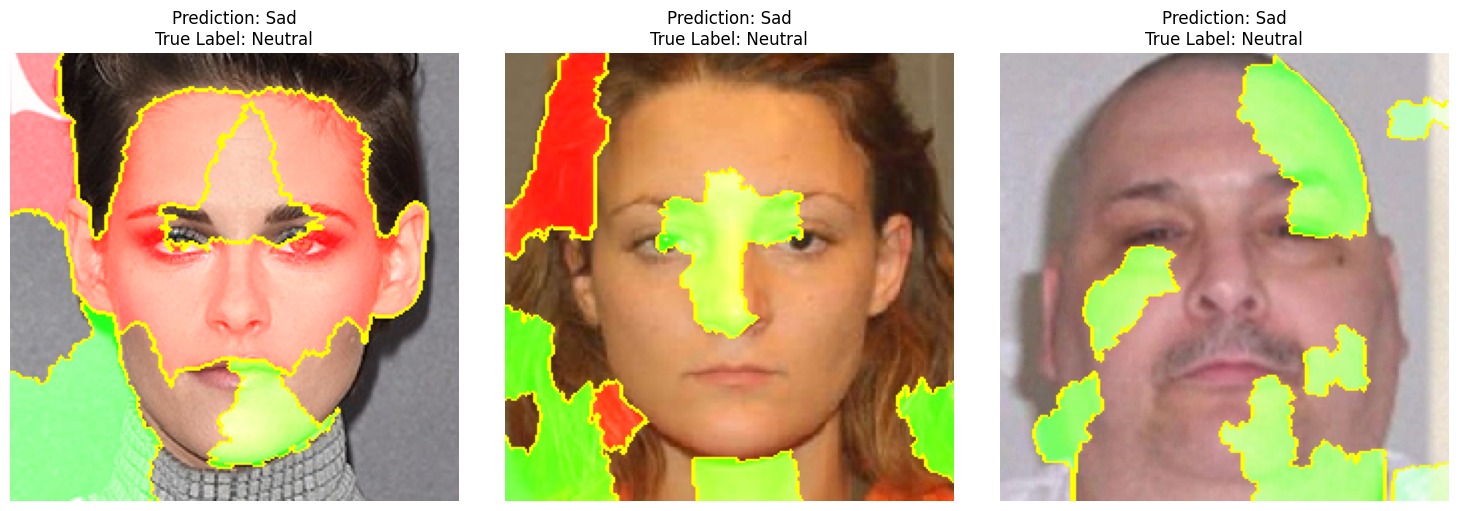

In [15]:
explain_prediction(model, test_generator, class_names, predicted_label=4, true_label=3, num_samples=3)

**True label: Sad / Predicted label: Sad**

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

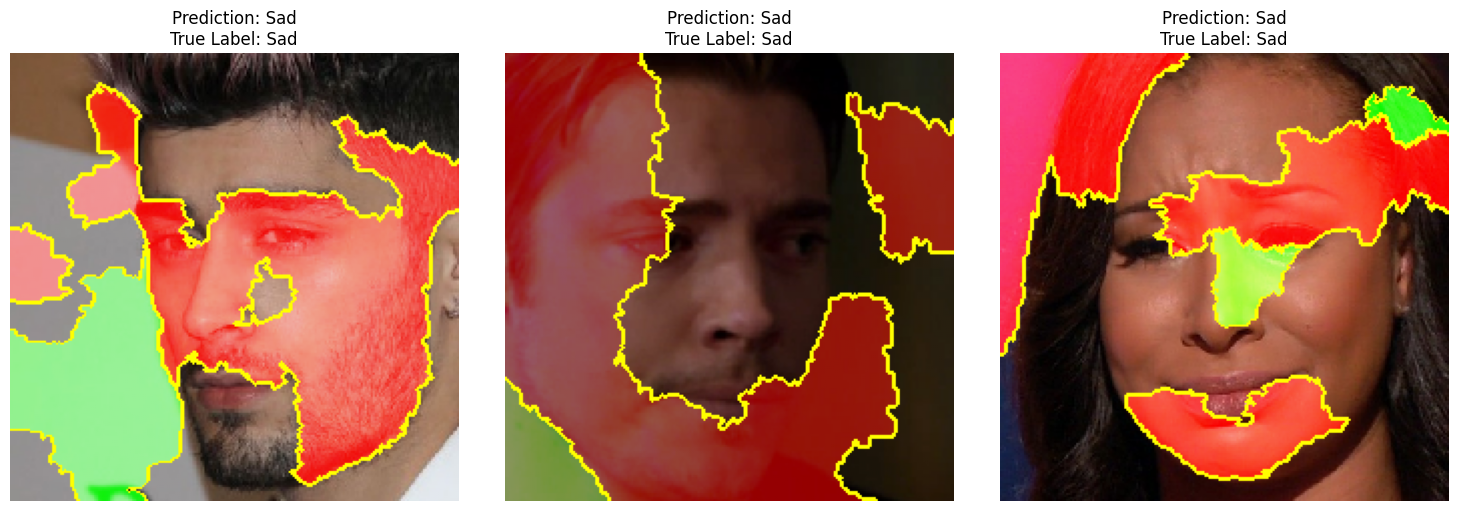

In [16]:
explain_prediction(model, test_generator, class_names, predicted_label=4, true_label=4, num_samples=3)

**True label: Neutral / Predicted label: Neutral**

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

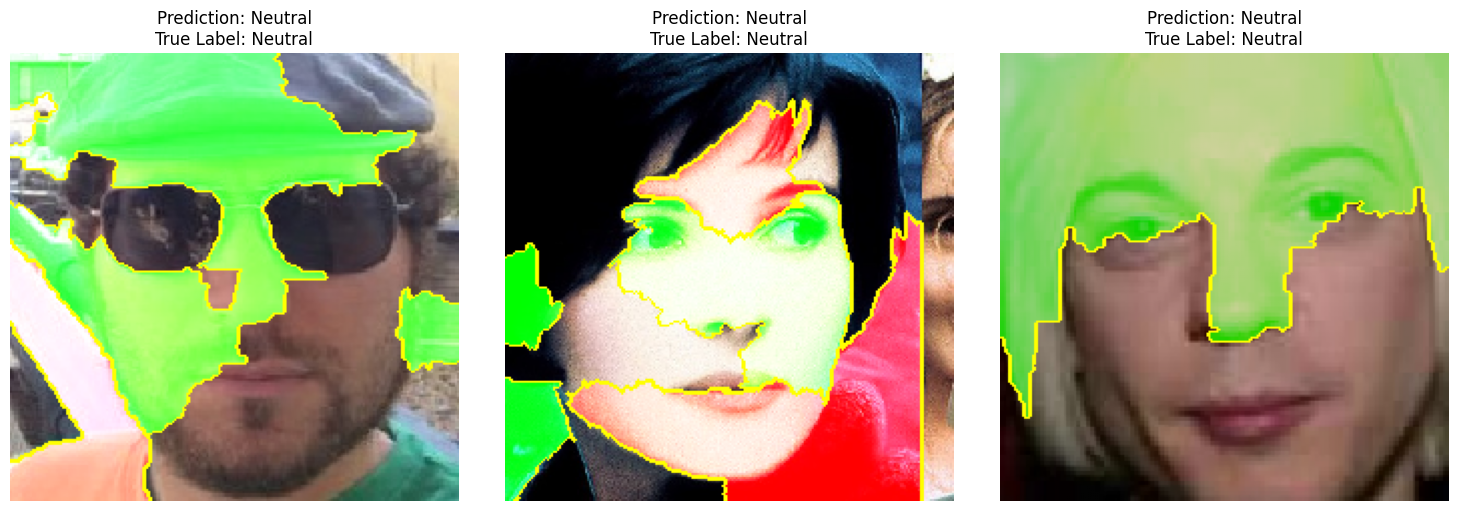

In [17]:
explain_prediction(model, test_generator, class_names, predicted_label=3, true_label=3, num_samples=3)

**Applying Gaussian Blur on Limited data**

In [18]:
# Define the preprocessing function
def preprocess_image(image):
    # Gaussian Blur
    processed_image = cv2.GaussianBlur(image, (3, 3), 0)
    
    return processed_image

# Define a function to apply preprocessing to each image
def custom_preprocessing_function(image):
    image = np.array(image, dtype=np.uint8)  # Ensure image is uint8 type for OpenCV
    image = preprocess_image(image)
    image = image.astype(np.float32)  # Convert back to float32 for further processing
    return image

# Prepare the data generators with preprocessing
train_val_proc_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    preprocessing_function=custom_preprocessing_function,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_proc_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing_function
)

# Assuming `train_metadata`, `val_metadata`, `base_dir`, and `class_names` are already defined
train_generator = train_val_proc_datagen.flow_from_dataframe(
    dataframe=train_val_data,
    directory=base_dir,
    x_col='path',
    y_col='label',
    batch_size=32,
    subset='training',
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224)
)

validation_generator = train_val_proc_datagen.flow_from_dataframe(
    dataframe=train_val_data,
    directory=base_dir,
    x_col='path',
    y_col='label',
    batch_size=32,
    subset='validation',
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224)
)

test_generator = test_proc_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=base_dir,
    x_col='path',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224)
)

Found 11126 validated image filenames belonging to 6 classes.
Found 2781 validated image filenames belonging to 6 classes.
Found 1546 validated image filenames belonging to 6 classes.


In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')  # Number of classes
])

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**tune**

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [22]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
for layer in base_model.layers:
    layer.trainable = False

In [24]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

In [25]:
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Train the Model**

In [27]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Evaluate the model
evaluation = model.evaluate(test_generator)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

Epoch 1/10


2024-07-24 18:33:55.978804: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-24 18:33:55.978856: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-24 18:33:55.978865: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-24 18:33:55.978873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-24 18:33:55.978881: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-07-24 18:33:55.978888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-07-24 18:33:55.978896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-07-24 18:33:55.978904: E external/local_xla/xla/se

217/348 ━━━━━━━━━━━━━━━━━━━━ 1:03 481ms/step - accuracy: 0.3245 - loss: 1.5994

2024-07-24 18:35:57.631923: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.29755, expected 3.68034
2024-07-24 18:35:57.631975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.79889, expected 4.18169
2024-07-24 18:35:57.631984: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.82377, expected 2.20656
2024-07-24 18:35:57.631992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.03137, expected 3.41417
2024-07-24 18:35:57.632000: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 5.11395, expected 4.49675
2024-07-24 18:35:57.632008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.78798, expected 4.17077
2024-07-24 18:35:57.632016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.85662, expected 4.23942
2024-07-24 18:35:57.632024: E external/local_xla/

348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.3445 - loss: 1.9437

2024-07-24 18:37:51.709750: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.5554, expected 3.07265
2024-07-24 18:37:51.709802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13778, expected 2.65504
2024-07-24 18:37:51.709812: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.34289, expected 2.86015
2024-07-24 18:37:51.709821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 3.72137, expected 3.23862
2024-07-24 18:37:51.709829: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198: 3.32536, expected 2.84261
2024-07-24 18:37:51.709837: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199: 3.81774, expected 3.335
2024-07-24 18:37:51.709845: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.84685, expected 2.36411
2024-07-24 18:37:51.709867: E external/local_xla

348/348 ━━━━━━━━━━━━━━━━━━━━ 255s 669ms/step - accuracy: 0.3446 - loss: 1.9447 - val_accuracy: 0.4880 - val_loss: 1.2637
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 212s 599ms/step - accuracy: 0.4415 - loss: 6.1678 - val_accuracy: 0.5160 - val_loss: 1.2009
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 209s 590ms/step - accuracy: 0.4886 - loss: 2.2420 - val_accuracy: 0.5063 - val_loss: 1.2002
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 208s 589ms/step - accuracy: 0.4805 - loss: 1.6776 - val_accuracy: 0.5261 - val_loss: 1.1825
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 208s 589ms/step - accuracy: 0.4821 - loss: 4.7800 - val_accuracy: 0.5491 - val_loss: 1.1224
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 211s 596ms/step - accuracy: 0.5267 - loss: 2.3115 - val_accuracy: 0.5484 - val_loss: 1.1181
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 210s 593ms/step - accuracy: 0.5188 - loss: 3.5891 - val_accuracy: 0.5523 - val_loss: 1.0956
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 208s 589ms/step - accuracy: 0.5390 - loss: 5.48

2024-07-24 19:09:38.380749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.17844, expected 3.56217
2024-07-24 19:09:38.380812: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.52289, expected 2.90662
2024-07-24 19:09:38.380822: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.66917, expected 4.05289
2024-07-24 19:09:38.380830: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.67338, expected 4.0571
2024-07-24 19:09:38.380838: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.6813, expected 4.06503
2024-07-24 19:09:38.380846: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.79963, expected 4.18336
2024-07-24 19:09:38.380854: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.73133, expected 4.11506
2024-07-24 19:09:38.380862: E external/local_xla/xl

49/49 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - accuracy: 0.5644 - loss: 1.4119
Test Loss: 10.043193817138672
Test Accuracy: 0.5666235685348511


In [28]:
y_pred_proba = model.predict(test_generator) 

49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step


In [29]:
y_true = test_generator.classes
y_pred = np.argmax(y_pred_proba, axis=1)

In [30]:
lb = LabelBinarizer()
y_true_binary = lb.fit_transform(y_true)
if y_true_binary.shape[1] == 1:
    y_true_binary = np.hstack((1 - y_true_binary, y_true_binary))

In [31]:
n_classes = len(test_generator.class_indices)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

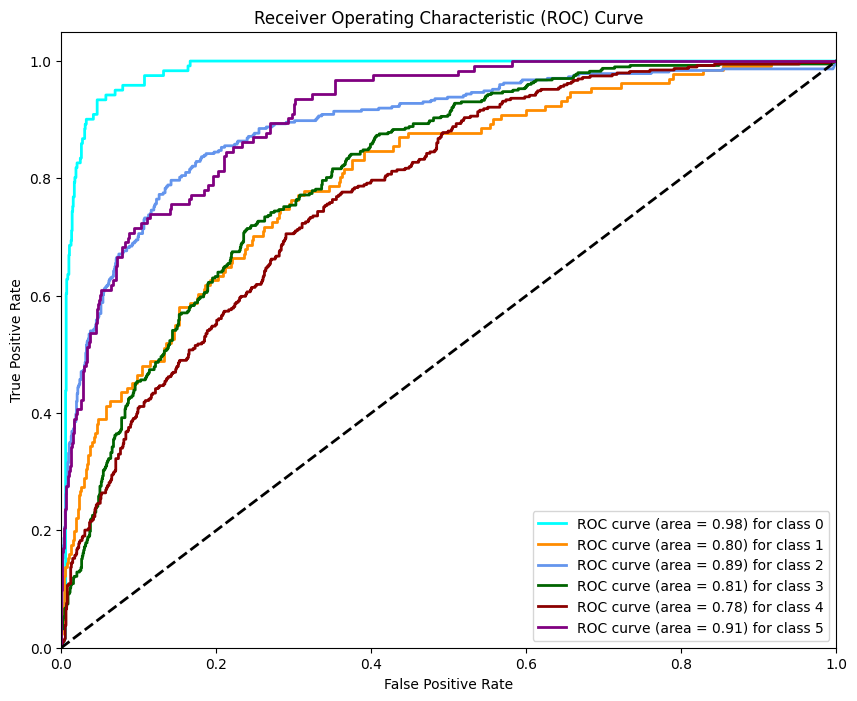

In [32]:
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [33]:
cm = confusion_matrix(y_true, y_pred)

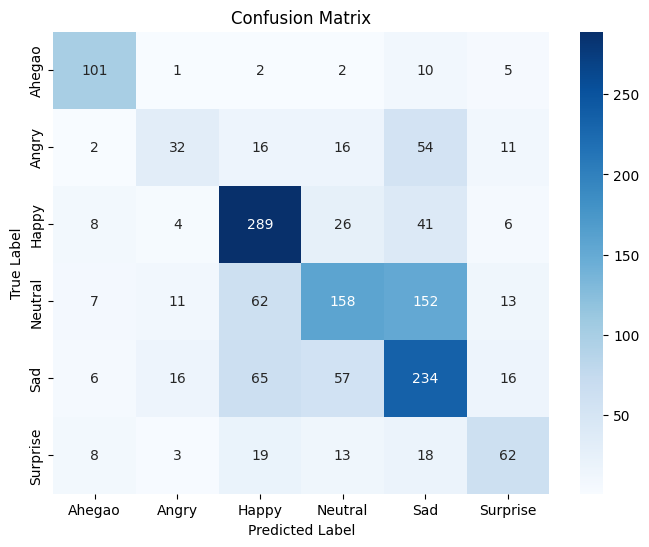

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
def explain_prediction(model, test_generator, class_names, predicted_label, true_label, num_samples=3):
    explainer = lime_image.LimeImageExplainer()

    images_to_show = []
    titles = []

    for _ in range(len(test_generator)):
        batch_images, batch_labels = next(test_generator)
        image = batch_images[0] * 255
        true_label_idx = np.argmax(batch_labels[0])
        
        if true_label_idx == true_label:
            image_resized = image / 255.0

            def predict(images):
                images = np.array([cv2.resize(img, (224, 224)) for img in images])
                return model.predict(images, verbose=0)

            explanation = explainer.explain_instance(image_resized, predict, top_labels=5, hide_color=0, num_samples=1000)
            temp, mask = explanation.get_image_and_mask(predicted_label, positive_only=False, num_features=10, hide_rest=False)
            temp = (temp * 255).astype(np.uint8)

            images_to_show.append(mark_boundaries(temp, mask))
            titles.append(f'Prediction: {class_names[predicted_label]}\nTrue Label: {class_names[true_label]}')

            num_samples -= 1
            if num_samples == 0:
                break

    num_images = len(images_to_show)
    num_rows = (num_images + 2) // 3
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i, (image, title) in enumerate(zip(images_to_show, titles)):
        row = i // 3
        col = i % 3
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

    for i in range(num_images, num_rows * 3):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

class_names = list(train_generator.class_indices.keys())


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

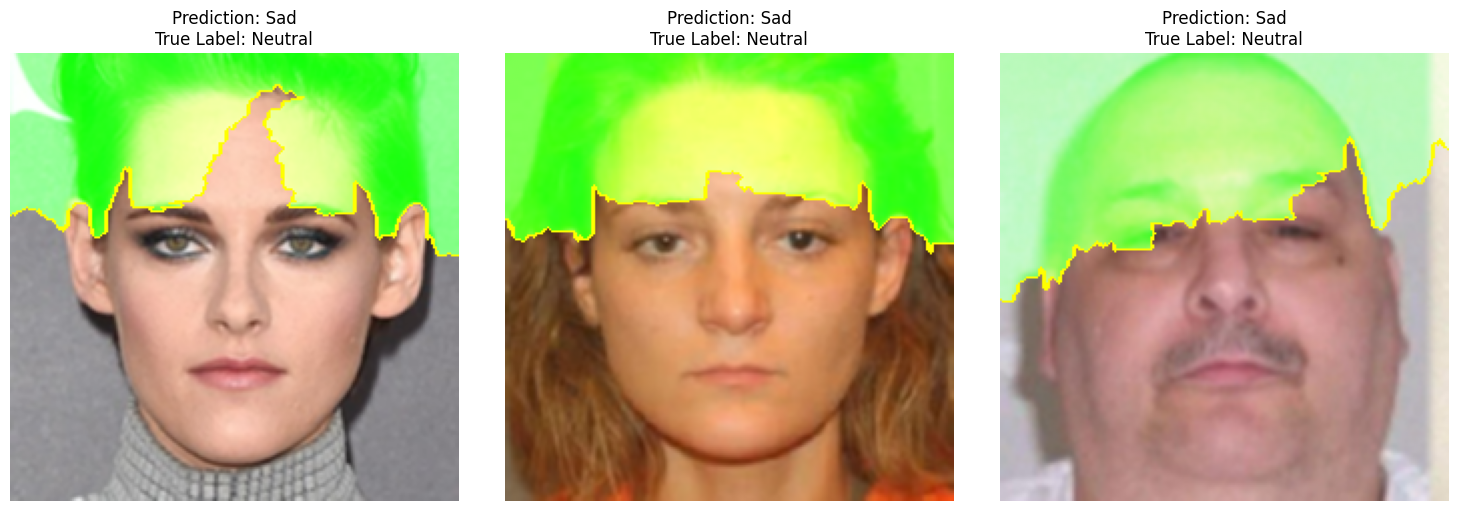

In [36]:
explain_prediction(model, test_generator, class_names, predicted_label=4, true_label=3, num_samples=3)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

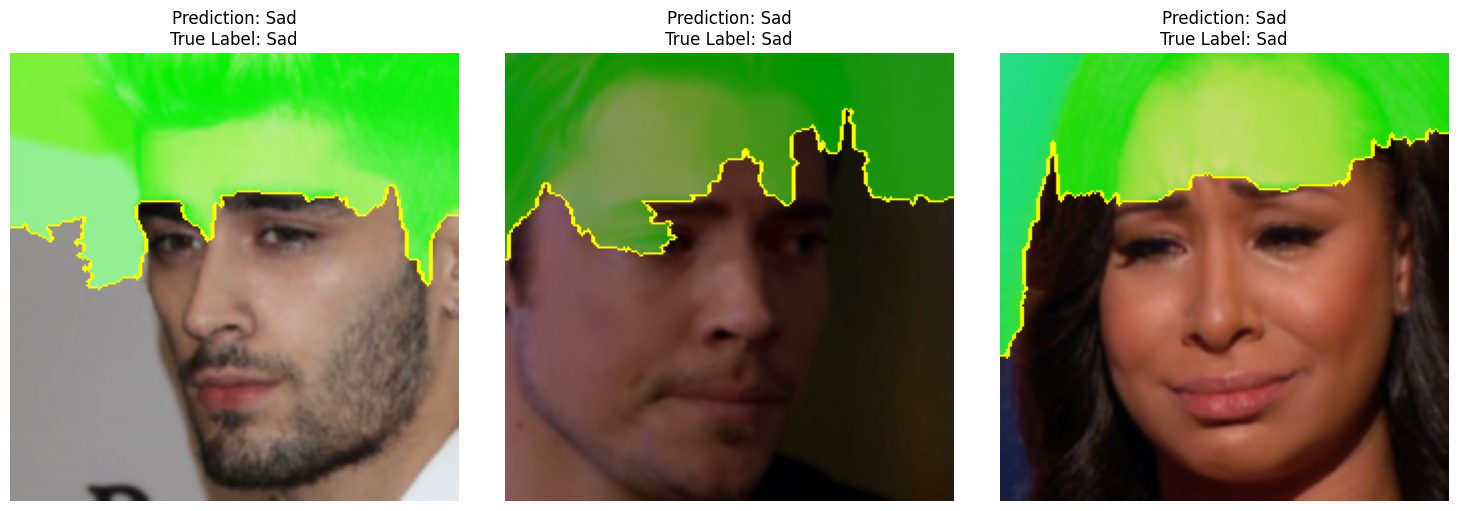

In [37]:
explain_prediction(model, test_generator, class_names, predicted_label=4, true_label=4, num_samples=3)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

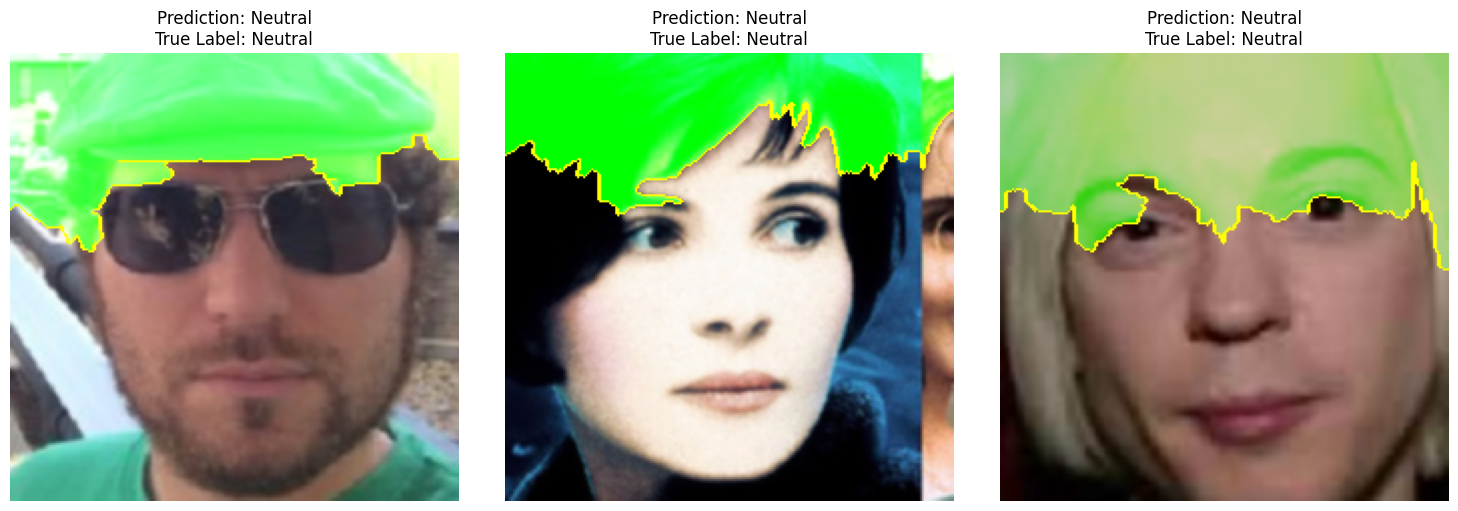

In [38]:
explain_prediction(model, test_generator, class_names, predicted_label=3, true_label=3, num_samples=3)

In [39]:
# Save the entire model to a file
model.save('fine_tuned_model.h5')
